## Week 2 Homework

> In case you don't get one option exactly, select the closest one 

For the homework, we'll be working with the _green_ taxi dataset located here:

`https://github.com/DataTalksClub/nyc-tlc-data/releases/tag/green/download`

### Assignment

The goal will be to construct an ETL pipeline that loads the data, performs some transformations, and writes the data to a database (and Google Cloud!).

- Create a new pipeline, call it `green_taxi_etl`
- Add a data loader block and use Pandas to read data for the final quarter of 2020 (months `10`, `11`, `12`).
  - You can use the same datatypes and date parsing methods shown in the course.
  - `BONUS`: load the final three months using a for loop and `pd.concat`
- Add a transformer block and perform the following:
  - Remove rows where the passenger count is equal to 0 _or_ the trip distance is equal to zero.
  - Create a new column `lpep_pickup_date` by converting `lpep_pickup_datetime` to a date.
  - Rename columns in Camel Case to Snake Case, e.g. `VendorID` to `vendor_id`.
  - Add three assertions:
    - `vendor_id` is one of the existing values in the column (currently)
    - `passenger_count` is greater than 0
    - `trip_distance` is greater than 0
- Using a Postgres data exporter (SQL or Python), write the dataset to a table called `green_taxi` in a schema `mage`. Replace the table if it already exists.
- Write your data as Parquet files to a bucket in GCP, partioned by `lpep_pickup_date`. Use the `pyarrow` library!
- Schedule your pipeline to run daily at 5AM UTC.

## SOLUTION
I created a new pipeline called green_taxi_etl, and added a data loader that loads green taxi trips of the last quarter of 2020 from a given URL. 


In [ ]:
"""
                    DATA LOADER
"""

import io
import pandas as pd
import requests
if 'data_loader' not in globals():
    from mage_ai.data_preparation.decorators import data_loader
if 'test' not in globals():
    from mage_ai.data_preparation.decorators import test


@data_loader
def load_data_from_api(*args, **kwargs):
    """
    Template for loading data from API
    """

    file_urls = [
        "https://github.com/DataTalksClub/nyc-tlc-data/releases/download/green/green_tripdata_2020-10.csv.gz",
        "https://github.com/DataTalksClub/nyc-tlc-data/releases/download/green/green_tripdata_2020-11.csv.gz",
        "https://github.com/DataTalksClub/nyc-tlc-data/releases/download/green/green_tripdata_2020-12.csv.gz"
    ]


    # Initialize an empty list to store DataFrames for each month
    dataframes = []
    
    #Define column data types
    taxi_dtypes = {
                    'VendorID': pd.Int64Dtype(),
                    'passenger_count': pd.Int64Dtype(),
                    'trip_distance': float,
                    'RatecodeID':pd.Int64Dtype(),
                    'store_and_fwd_flag':str,
                    'PULocationID':pd.Int64Dtype(),
                    'DOLocationID':pd.Int64Dtype(),
                    'payment_type': pd.Int64Dtype(),
                    'fare_amount': float,
                    'extra':float,
                    'mta_tax':float,
                    'tip_amount':float,
                    'tolls_amount':float,
                    'improvement_surcharge':float,
                    'total_amount':float,
                    'congestion_surcharge':float
                }

    
    # native date parsing 
    parse_dates = ['lpep_pickup_datetime', 'lpep_dropoff_datetime']

# Use a for loop to download, decompress, and read each file, then append the DataFrame to the list
    for file_url in file_urls:     
    
        # Read the CSV data into a DataFrame with specified data types and date parsing
            df = pd.read_csv(file_url, sep=',', compression='gzip', dtype=taxi_dtypes, parse_dates=parse_dates)
        # Append the DataFrame to the list
            dataframes.append(df)

# Concatenate the DataFrames in the list along the rows (axis=0)
    result_df = pd.concat(dataframes, axis=0, ignore_index=True)
   

    return result_df


@test
def test_output(output, *args) -> None:
    """
    Template code for testing the output of the block.
    """
    assert output is not None, 'The output is undefined'

## Question 1. Data Loading
Once the dataset is loaded, what's the shape of the data?

* **266,855 rows x 20 columns**
* 544,898 rows x 18 columns
* 544,898 rows x 20 columns
* 133,744 rows x 20 columns

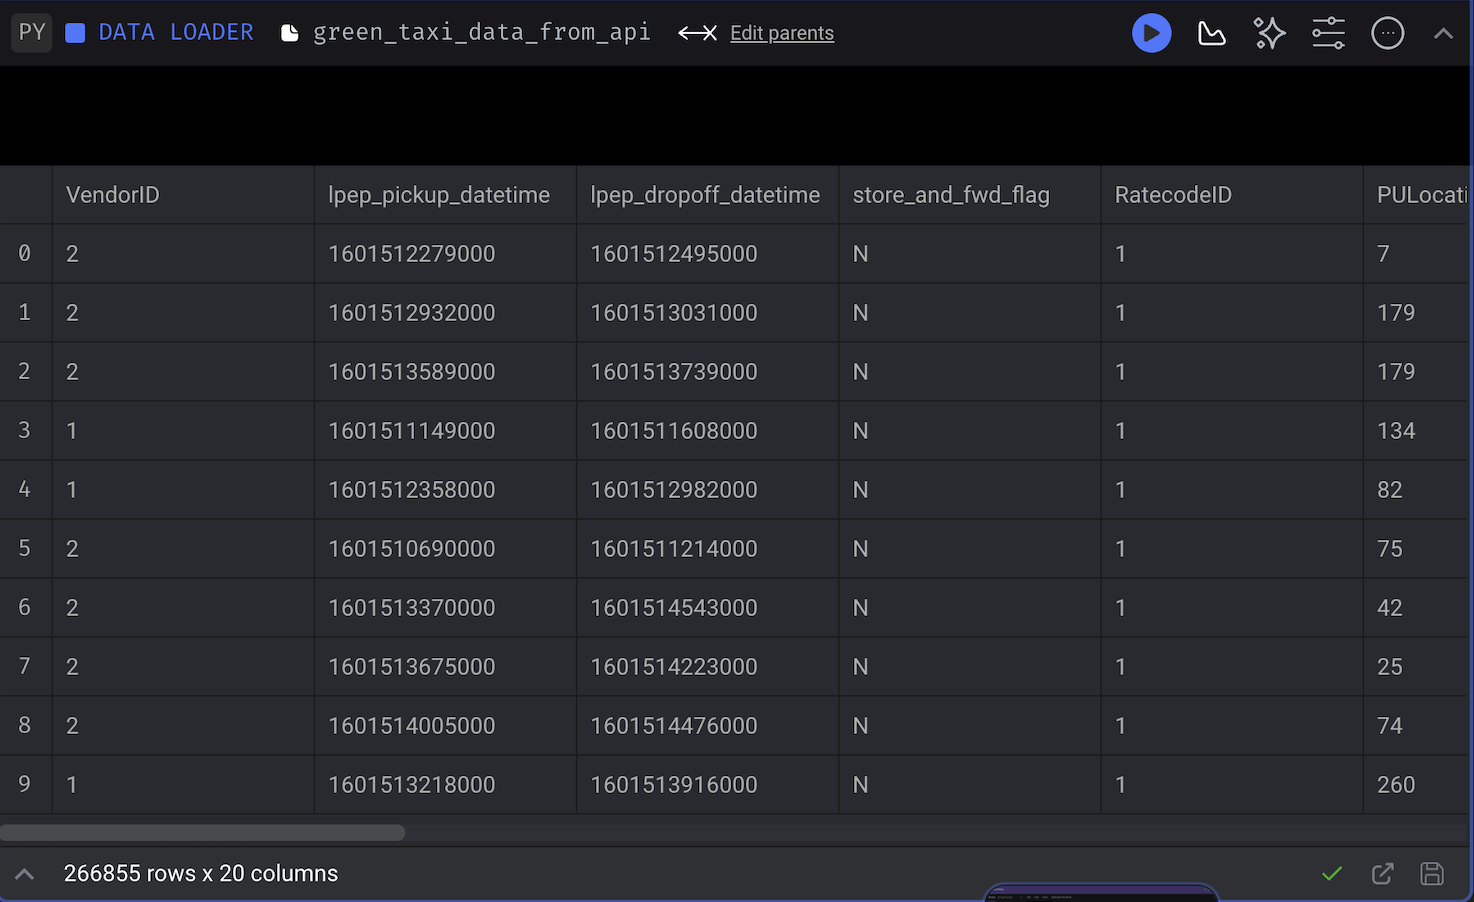

In [ ]:
"""
                    DATA TRANSFORMER
"""
import re
if 'transformer' not in globals():
    from mage_ai.data_preparation.decorators import transformer
if 'test' not in globals():
    from mage_ai.data_preparation.decorators import test

def camel_to_snake(name):
    """
    Convert Camel Case to Snake Case.
    """
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name)
    return name.lower()

@transformer
def transform(data, *args, **kwargs):
    """
    Template code for a transformer block.

    Add more parameters to this function if this block has multiple parent blocks.
    There should be one parameter for each output variable from each parent block.

    Args:
        data: The output from the upstream parent block
        args: The output from any additional upstream blocks (if applicable)

    Returns:
        Anything (e.g. data frame, dictionary, array, int, str, etc.)
    """
    # Specify your transformation logic here

    # Transformer block
    # Remove rows where passenger count or trip distance is zero
    data = data[(data['passenger_count'] > 0) & (data['trip_distance'] > 0)]
        
    # Create a new column lpep_pickup_date by converting lpep_pickup_datetime to a date
    data['lpep_pickup_date'] = data['lpep_pickup_datetime'].dt.date

    # Rename columns from Camel Case to Snake Case
    # Determine the columns requiring renaming
    columns_before = data.columns
    columns_after = [camel_to_snake(col) for col in data.columns]

    columns_to_rename = [col_before for col_before, col_after in zip(columns_before, columns_after) if col_before != col_after]

# Count the number of columns to be renamed
    num_columns_to_rename = len(columns_to_rename)

    print(f"Number of columns to be renamed: {num_columns_to_rename}")
    print("Columns to be renamed:", columns_to_rename)

    data.columns = [camel_to_snake(col) for col in data.columns]
    
    #finding existing values of vendor_id in the dataset

    print("Existing values of VendorID:", data['vendor_id'].unique())
   
        
    return data


@test
def test_output(output, *args):
    """
    Template code for testing the output of the block.
    """
    # Assertions
    assert (output['vendor_id'].isin([1, 2])).all(), "Assertion Error: vendor_id is not one of the existing values."
    assert (output['passenger_count'] > 0).all(), "Assertion Error: passenger_count is not greater than 0."
    assert (output['trip_distance'] > 0).all(), "Assertion Error: trip_distance is not greater than 0."


## Question 2. Data Transformation

Upon filtering the dataset where the passenger count is greater than 0 _and_ the trip distance is greater than zero, how many rows are left?

* 544,897 rows
* 266,855 rows
* **139,370 rows**
* 266,856 rows

## Question 3. Data Transformation

Which of the following creates a new column `lpep_pickup_date` by converting `lpep_pickup_datetime` to a date?

* `data = data['lpep_pickup_datetime'].date`
* `data('lpep_pickup_date') = data['lpep_pickup_datetime'].date`
* **`data['lpep_pickup_date'] = data['lpep_pickup_datetime'].dt.date`**
* `data['lpep_pickup_date'] = data['lpep_pickup_datetime'].dt().date()`

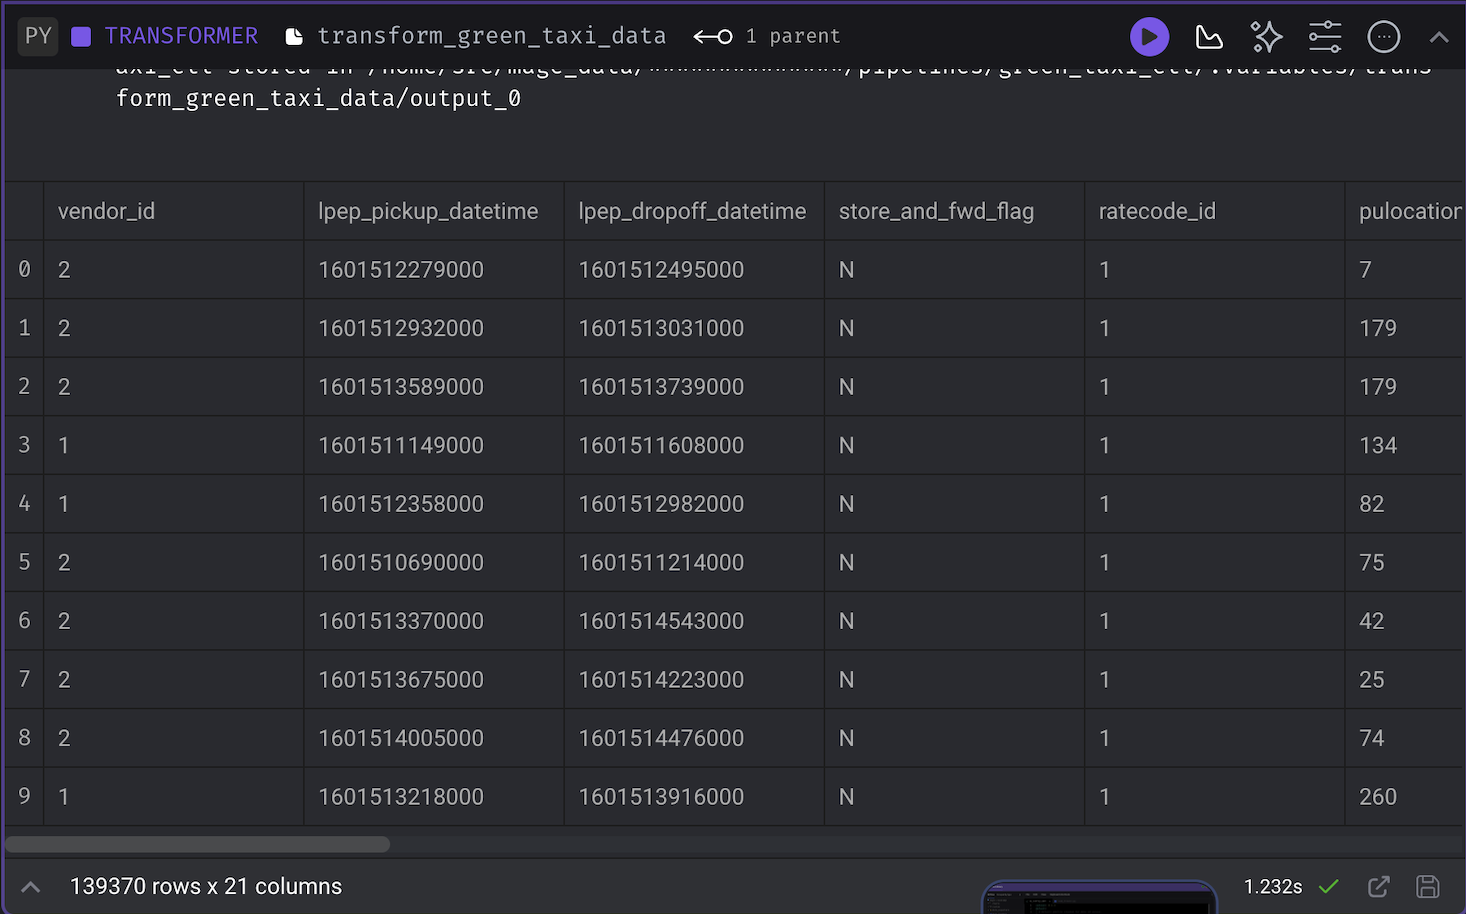

## Question 4. Data Transformation
​
What are the existing values of `VendorID` in the dataset?
​
* 1, 2, or 3
* **1 or 2**
* 1, 2, 3, 4
* 1
​
## Question 5. Data Transformation
​
How many columns need to be renamed to snake case?
​
* 3
* 6
* 2
* **4**

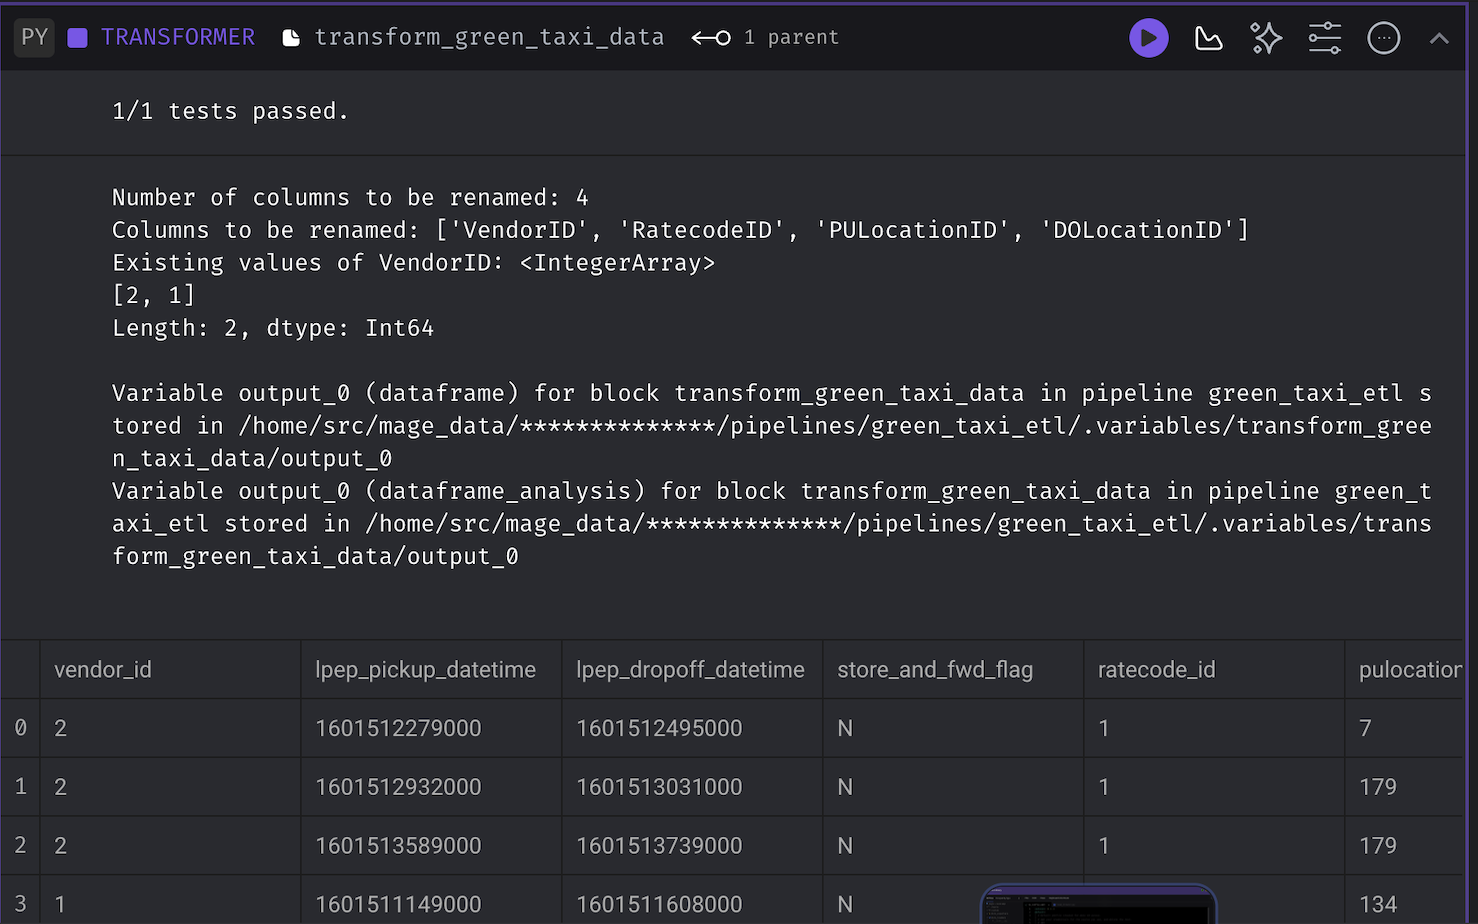

In [ ]:
"""
            DATA EXPORTER TO POSTGRES
"""
from mage_ai.settings.repo import get_repo_path
from mage_ai.io.config import ConfigFileLoader
from mage_ai.io.postgres import Postgres
from pandas import DataFrame
from os import path

if 'data_exporter' not in globals():
    from mage_ai.data_preparation.decorators import data_exporter


@data_exporter
def export_data_to_postgres(df: DataFrame, **kwargs) -> None:
    """
    Template for exporting data to a PostgreSQL database.
    Specify your configuration settings in 'io_config.yaml'.

    Docs: https://docs.mage.ai/design/data-loading#postgresql
    """
    schema_name = 'mage'  # Specify the name of the schema to export data to
    table_name = 'green_taxi'  # Specify the name of the table to export data to
    config_path = path.join(get_repo_path(), 'io_config.yaml')
    config_profile = 'dev'

    with Postgres.with_config(ConfigFileLoader(config_path, config_profile)) as loader:
        loader.export(
            df,
            schema_name,
            table_name,
            index=False,  # Specifies whether to include index in exported table
            if_exists='replace',  # Specify resolution policy if table name already exists
        )

In [ ]:
"""
        DATA LOADER FROM POSTGRES
"""

-- Docs: https://docs.mage.ai/guides/sql-blocks
SELECT *
FROM mage.green_taxi
LIMIT 10;

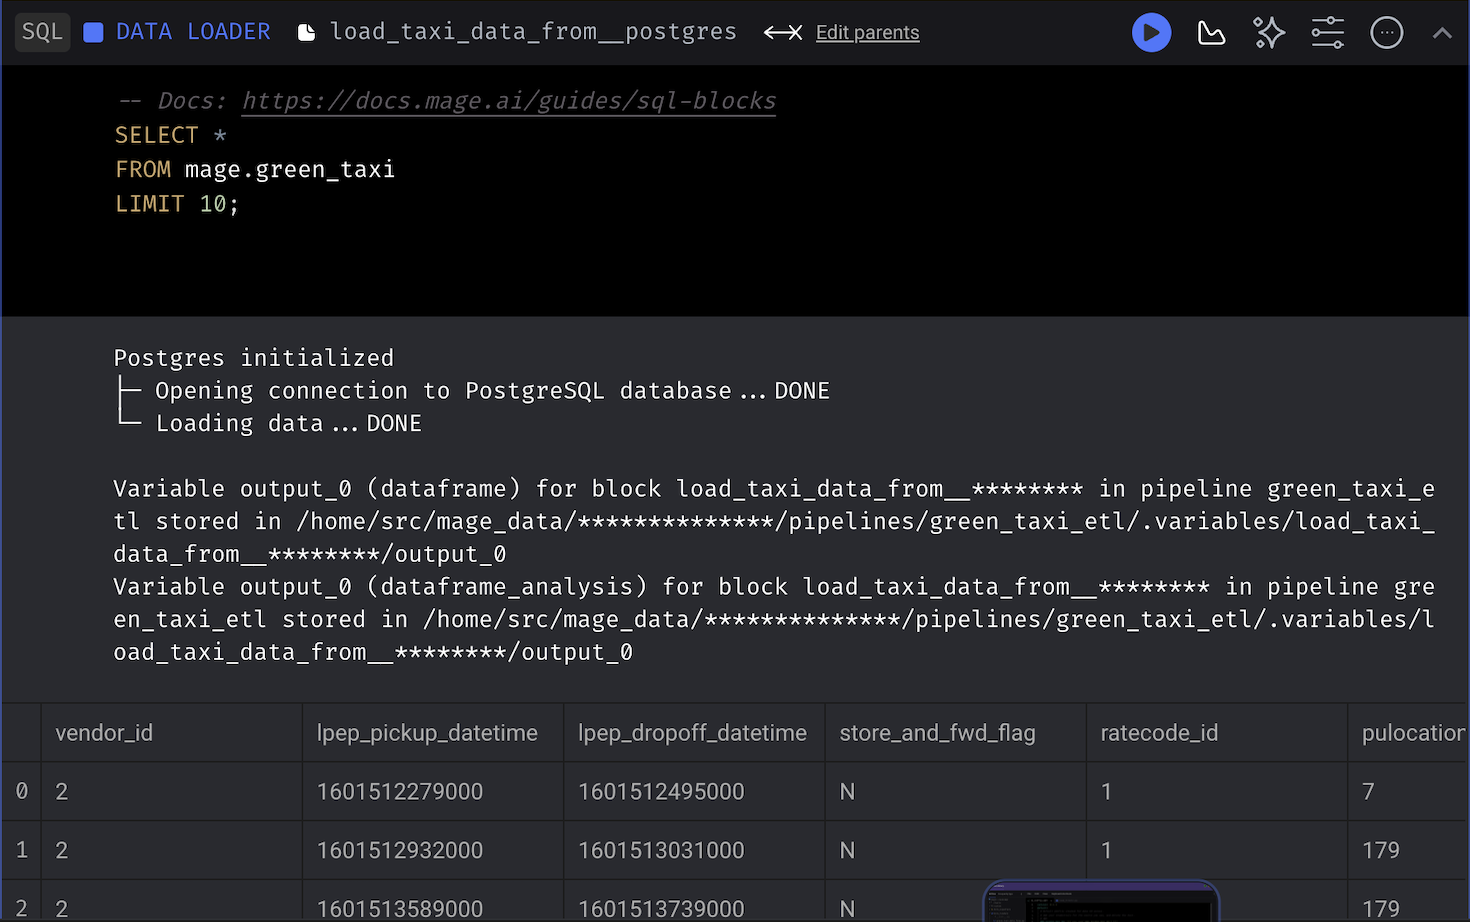

In [ ]:
"""
            DATA EXPORTER TO GOOGLE CLOUD STORAGE
"""
import pyarrow as pa
import pyarrow.parquet as pq 
import os 

if 'data_exporter' not in globals():
    from mage_ai.data_preparation.decorators import data_exporter

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/home/src/dtc-de-course-380621-f9524e48f9c0.json"


bucket_name = 'meme_mage_zoomcamp'
project_id = 'dtc-de-course-380621'

table_name = 'green_taxi'

root_path = f'{bucket_name}/{table_name}'



@data_exporter
def export_data(data, *args, **kwargs):

    table = pa.Table.from_pandas(data)

    gcs = pa.fs.GcsFileSystem()

    pq.write_to_dataset(
        table,
        root_path=root_path,
        partition_cols=['lpep_pickup_date'],
        filesystem=gcs
    )

## Question 6. Data Exporting

Once exported, how many partitions (folders) are present in Google Cloud?

* **96**
* 56
* 67
* 108

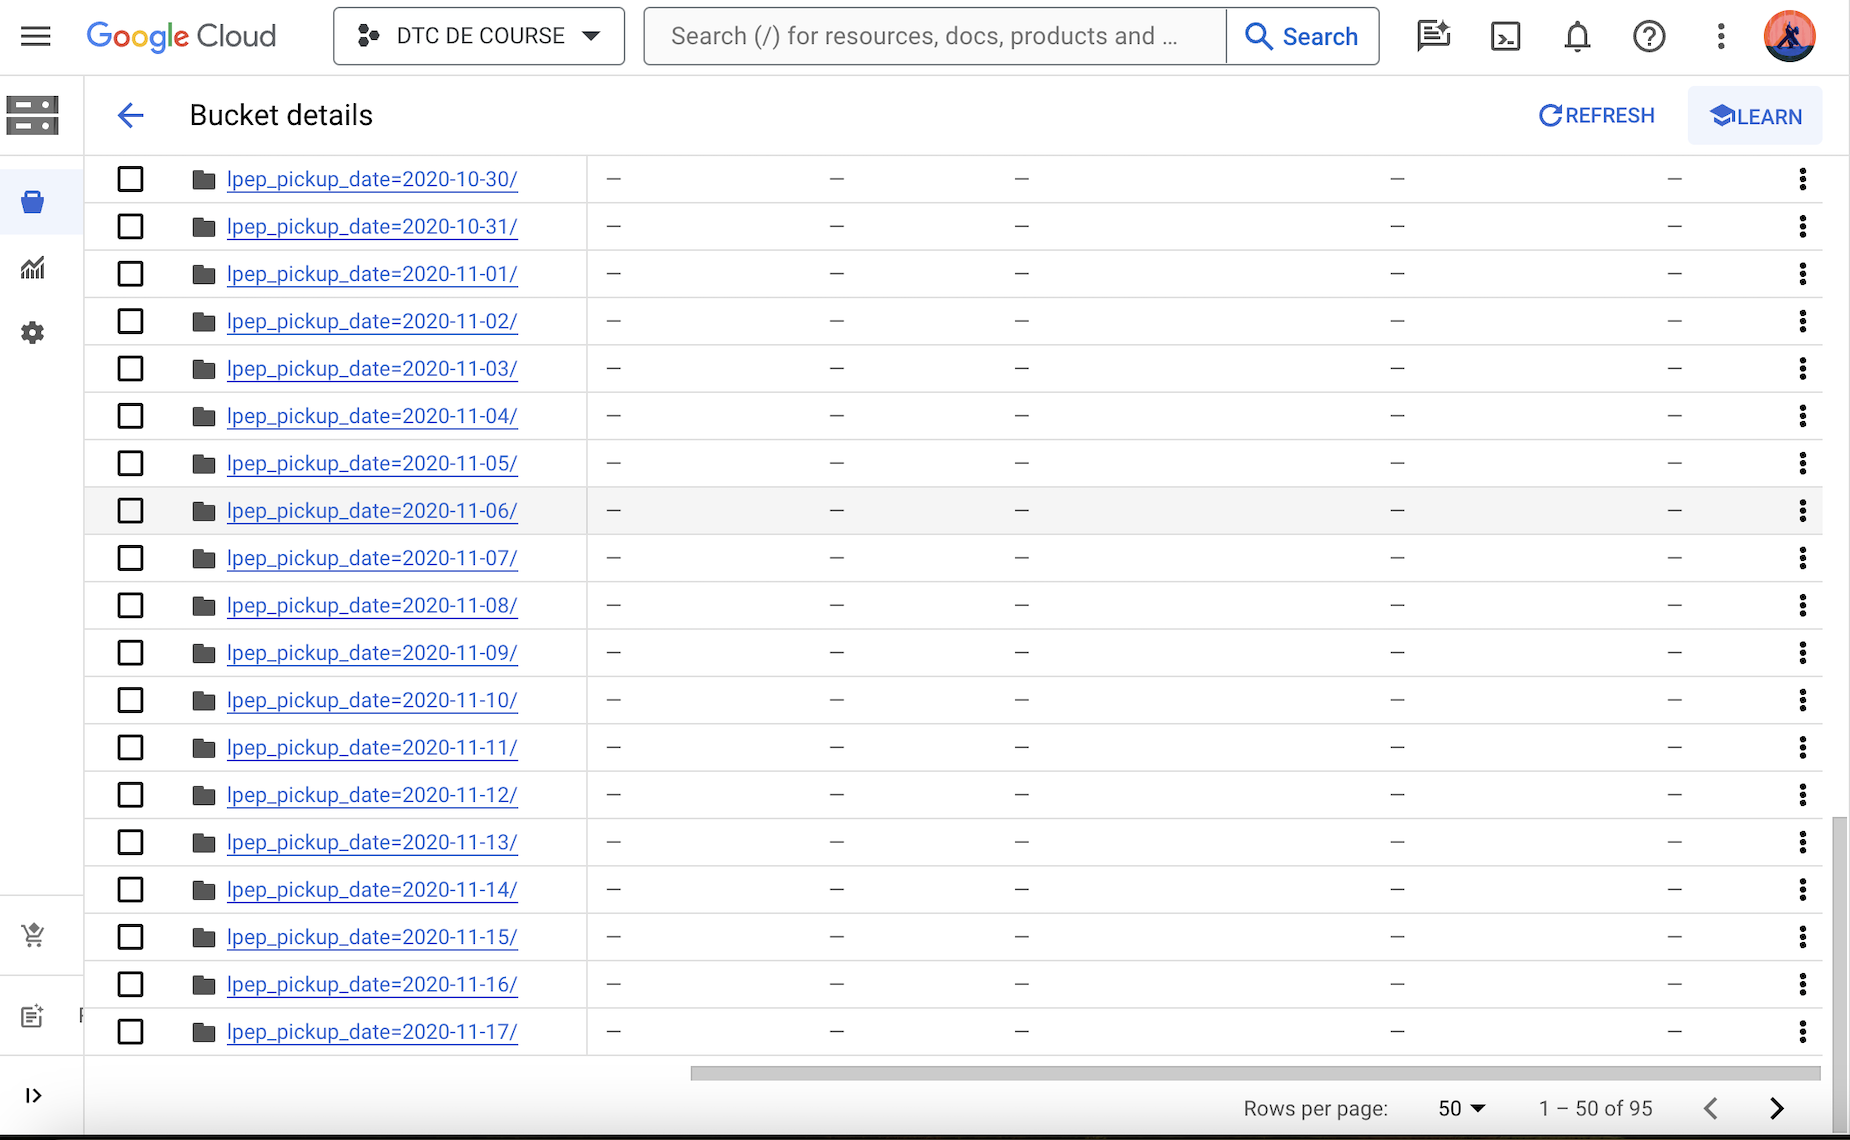